# Topic Modelling dengan LSA dan LDA

## Import Library

### Library yang digunakan

- **Pandas**\
    Untuk manipulasi dan membaca data dalam bentuk tabel. 

- **matplotlib**\
    Untuk membuat visualisasi data.

- **PySastrawi**\
    Untuk melakukan text processing.

- **scikit-learn**\
    Untuk menghitung TF dan TF-IDF.

- **WordCloud**\
    Untuk visualisasi kata yang paling sering muncul. 

In [1]:
# visualisasi data dan manipulasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from wordcloud import WordCloud

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')

# Pre-processing
import re
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Melakukan setting jumlah kolom maksimal pada output
pd.options.display.max_columns = 10

## Membaca Data

Dataset yang digunakan : [link](https://github.com/egi-190137/topic-modelling-sklearn/blob/main/contents/dataset_pta.csv)

Dataset yang digunakan merupakan hasil dari crawling judul dan abstraksi jurnal yang telah ditambah nilai kolom bidang minat dan dihapus duplikasi data-nya.

In [3]:
df = pd.read_csv('dataset_pta.csv')

In [4]:
df.head()

,judul,abstraksi,bidang minat
0,Gerak Pekerja Pada Game Real Time Strategy Men...,Gerak pekerja ada pada game yang memiliki genr...,CAI
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...,Penyusunan Sistem Informasi Dinas Perindustria...,RPL
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...,Penggunaan teknologi mobile saat ini sangat ma...,RPL
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...,Sumber daya manusia mutlak dibutuhkan untuk ke...,CAI
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...,Di Indonesia masalah perkembangan gizi adalah ...,CAI


Data yang digunakan dalam program ini hanya data pada kolom 'judul'. Untuk mengambil kolom 'judul' saja dapat dilakukan dengan inisialisasi ulang df dengan df[['judul']] 

In [5]:
df = df[['judul']]
df.head()

,judul
0,Gerak Pekerja Pada Game Real Time Strategy Men...
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...


## Pre-processing Data

Terdapat beberapa tahapan dalam melakukan Pre-processing data, diantaranya *case folding* (Mengubah teks menjadi *lower case*), menghapus angka dan tanda baca, menghapus white space dan *stopword removal*. Semua tahapan *pre-processing* tersebut saya masukkan ke dalam fungsi clean_text, kemudian saya aplikasikan pada data judul pada dataframe dengan method **.apply(clean_text)**. 

Untuk menghapus stopword saya menggunakan library **PySastrawi**, karena **PySastrawi** memiliki list stopword bahasa indonesia yang lebih lengkap daripada library **nltk**.

Pada Library **PySastrawi** penghapusan stopword dilakukan dengan membuata objek StopWordRemoverFactory, kemudian buat objek stopword remover dengan method create_stop_word_remover. Objek stopword remover memiliki method remove yang dapat digunakan untuk menghapus stopword dalam sebuah kalimat dengan memasukkan string ke dalam parameter method remove.  

In [6]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [7]:
def clean_text(text):
  # Mengubah teks menjadi lowercase
  cleaned_text = text.lower()
  # Menghapus angka
  cleaned_text = re.sub(r"\d+", "", cleaned_text)
  # Menghapus white space
  cleaned_text = cleaned_text.strip()
  # Menghapus tanda baca
  cleaned_text = cleaned_text.translate(str.maketrans("","",string.punctuation))
  # Hapus stopword
  cleaned_text = stopword.remove(cleaned_text)
  return cleaned_text
  

In [8]:
# time taking
df['cleaned_judul'] = df['judul'].apply(clean_text)

### Perbedaan data awal dengan data yang telah di-preprocessing

In [9]:
df.head()

,judul,cleaned_judul
0,Gerak Pekerja Pada Game Real Time Strategy Men...,gerak pekerja game real time strategy finite s...
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...,pemanfaatan togaf adm perancangan sistem infor...
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...,rancang bangun manajemen pembelajaran tes toef...
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...,sistem pendukung keputusan pemilihan karyawan ...
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...,sistem penentuan status gizi pasien rawat inap...


### Hapus kolom 'judul'

In [10]:
df.drop(['judul'],axis=1,inplace=True)

### Mengganti nama kolom __cleaned_judul__ dengan __judul__ 

In [11]:
df.columns = ['judul']

In [12]:
df.head()

,judul
0,gerak pekerja game real time strategy finite s...
1,pemanfaatan togaf adm perancangan sistem infor...
2,rancang bangun manajemen pembelajaran tes toef...
3,sistem pendukung keputusan pemilihan karyawan ...
4,sistem penentuan status gizi pasien rawat inap...


### Contoh judul yang telah di lakukan *pre-processing*

In [13]:
df['judul'][0]

'gerak pekerja game real time strategy finite state machine'

## Ekstraksi fitur dan membuat Document Term Matrix (DTM)

Dalam perhitungan LSA (Latent Semantic Analysis) data yang diperlukan hanya TF-IDF. Sehingga pada program ini tidak perlu mencari nilai TF dari dokumen. Untuk mengetahui nilai TF-IDF dapat dilakukan dengan membuat objek dari kelas TfidfVectorizer yang disediakan library scikit-learn.

Rumus Term Frequency:

$$
tf(t,d) = { f_{ t,d } \over \sum_{t' \in d } f_{t,d}}
$$

$ f_{ t,d } \quad\quad\quad\quad$: Jumlah kata t muncul dalam dokumen

$ \sum_{t' \in d } f_{t,d} \quad\quad$: Jumlah seluruh kata yang ada dalam dokumen

Rumus Inverse Document Frequency:

$$
idf( t,D ) = log { N \over { | \{ d \in D:t \in d \} | } }
$$

$ N \quad\quad\quad\quad\quad$ : Jumlah seluruh dokumen

$ | \{ d \in D:t \in d \} | $ : Jumlah dokumen yang mengandung kata $ t $

Rumus Inverse Document Frequency:

$$
tfidf( t,d,D ) = tf( t,d ) \times idf( t,D )
$$

In [14]:
vect = TfidfVectorizer()

Setelah objek **TfidfVectorizer** dibuat gunakan method **fit_transform** dengan argumen data yang akan dicari nilai **TF-IDF**-nya

In [15]:
vect_text = vect.fit_transform(df['judul'])

In [16]:
attr_count = vect.get_feature_names_out().shape[0]
print(f'Jumlah atribut dalam Document-Term Matrix : {attr_count}')

Jumlah atribut dalam Document-Term Matrix : 358


#### Menyimpan hasil tfidf ke dalam DataFrame

Hasil tfidf perlu diubah terlebih dahulu menjadi array agar dapat digunakan sebagai data. Kemudian untuk parameter kolom-nya dapat didapatkan menggunakan method get_feature_names_out pada objek TfidfVectorizer.

In [17]:
tfidf = pd.DataFrame(
    data=vect_text.toarray(),
    columns=vect.get_feature_names_out()
)
tfidf.head()

,acute,addie,additive,additiveweighting,adm,...,wafa,wajah,web,weight,weighting
0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.300817,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0


Mencari nilai **idf** dengan mengakses atribut **idf_** pada objek **tfidfVectorizer**. Atribut **idf_** hanya terdefinisi apabila parameter **use_idf** saat instansiasi objekk tfidfVectorizer bernilai **True**. Namun, **use_idf** sudah bernilai **True** secara default, sehingga kita dapat perlu menentukannya secara manual. 

In [18]:
idf = vect.idf_

In [19]:
dd= dict(zip(vect.get_feature_names_out(), idf))

l = sorted(dd, key = dd.get)

Kita dapat melihat kata yang paling sering dan paling jarang muncul pada judul tugas akhir berdasarkan nilai idf. Kata yang memiliki nilai lebih kecil, adalah kata yang paling sering muncul dalam judul

In [20]:
print("5 Kata paling sering muncul:")
for i, word in enumerate(l[:5]):
    print(f"{i+1}. {word}\t(Nilai idf: {dd[word]})")

5 Kata paling sering muncul:
1. sistem	(Nilai idf: 1.709676482511156)
2. metode	(Nilai idf: 1.9753796482441615)
3. berbasis	(Nilai idf: 2.11514159061932)
4. studi	(Nilai idf: 2.220502106277147)
5. rancang	(Nilai idf: 2.3382851419335298)


In [21]:
print("5 Kata paling jarang muncul:")
for i, word in enumerate(l[:-5:-1]):
    print(f"{i+1}. {word}\t(Nilai idf: {dd[word]})")

5 Kata paling jarang muncul:
1. weighting	(Nilai idf: 4.417726683613366)
2. weight	(Nilai idf: 4.417726683613366)
3. wajah	(Nilai idf: 4.417726683613366)
4. wafa	(Nilai idf: 4.417726683613366)


## TOPIC MODELLING

### Latent Semantic Analysis (LSA)

Latent Semantic Analysis (LSA) merupakan sebuah metode yang memanfaatkan model statistik matematis untuk menganalisa struktur semantik suatu teks. LSA bisa digunakan untuk menilai judul tugas akhir dengan mengkonversikan judul tugas akhir menjadi matriks-matriks yang diberi nilai pada masing-masing term untuk dicari kesamaan dengan term. Secara umum, langkah-langkah LSA dalam penilaian judul tugas akhir adalah sebagai berikut:

1. Text Processing
2. Document-Term Matrix
3. Singular Value Decomposition (SVD)
4. Cosine Similarity Measurement

#### Singular Value Decomposition

Singular Value Decomposition (SVD) adalah sebuah teknik untuk mereduksi dimensi yang bermanfaat untuk memperkecil nilai kompleksitas dalam pemrosesan Document-Term Matrix. SVD merupakan teorema aljabar linier yang menyebutkan bahwa persegi panjang dari Document-Term Matrix dapat dipecah/didekomposisikan menjadi tiga matriks, yaitu Matriks ortogonal U, Matriks diagonal S, Transpose dari matriks ortogonal V.

$$
A_{mn} = U_{mm} \times S_{mn} \times V^{T}_{nn}
$$

$ A_{mn} $ : matriks awal

$ U_{mm} $ : matriks ortogonal

$ S_{mn} $ : matriks diagonal

$ V^{T}_{nn} $ : Transpose matriks ortogonal V

Setiap baris dari matriks $ U $ (Document-Term Matrix) adalah bentuk vektor dari dokumen. Panjang dari vektor-vektor tersebut adalah jumlah topik. Sedangkan matriks $ V $ (Term-Topic Matrix) berisi kata-kata dari data.

SVD akan memberikan vektor untuk setiap dokumen dan kata dalam data. Kita dapat menggunakan vektor-vektor tersebut untuk mencari kata dan dokumen serupa menggunakan metode **Cosine Similarity**.

Dalam mengimplementasikan LSA, dapat menggunakan fungsi TruncatedSVD. parameter n_components digunakan untuk menentukan jumlah topik yang akan diekstrak.



In [22]:
lsa_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [23]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print(f"Topic {i} : {topic*100}")

Document 0 :
Topic 0 : 1.3810694835999033
Topic 1 : -3.384805564095132


In [24]:
(count_topic, count_word) = lsa_model.components_.shape
print(f"Jumlah topik\t: {count_topic}")
print(f"Jumlah kata\t: {count_word}")

Jumlah topik	: 2
Jumlah kata	: 358


Sekarang kita dapat mendapatkan daftar kata yang penting untuk setiap topik. Jumlah kata yang akan ditampilkan hanya 10. Untuk melakukan sorting dapat menggunakan fungsi sorted, lalu slicing dengan menambahkan \[:10\] agar data yang diambil hanya 10 data pertama. Slicing dilakukan berdasarkan nilai pada indeks 1 karena nilai dari nilai lsa.

In [25]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)

    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print(f"Topic {i}: ")
    print(" ".join([ item[0] for item in sorted_words ]))
    print("")
         

Topic 0: 
studi sistem bangun rancang informasi madura berbasis trunojoyo universitas pembelajaran

Topic 1: 
keputusan pendukung metode sistem topsis penentuan pemilihan saw penilaian unggulan



### Latent Dirichlet Allocation (LDA)  

![Model LDA](img/dw-1.jpg)

*Latent Dirichlet Allocation (LDA)* adalah model generatif statistik yang dari koleksi data diskrit seperti kumpulan dokumen (*corpus*).

![Konsep LDA](img/dw-3.jpg)

Awal dibuatnya LDA yaitu bahwa dokumen terdiri dari beberapa topik.  Proses mengasumsikan bahwa dokumen berasal dari topik tertentu melalui *imaginary random process*. Setiap topik dibentuk oleh distribusi kata-kata.

![Konsep LDA](img/dw-4.jpg)

Topik yang mendeskripsikan kumpulan dari suatu dokumen dapat ditentukan setalah topik LDA dibuat. Pada sisi sebelah kanan gambar diatas menunjukkan daftar topik serta 15 kata dengan distribusi tertinggi untuk masing-masing topik tersebut. 

Rumus Dirichlet Distribution:
$$
f\left(x_{1}, \ldots, x_{K} ; \alpha_{1}, \ldots, \alpha_{K}\right)=\frac{\Gamma\left(\sum_{i=1}^{K} \alpha_{i}\right)}{\prod_{i=1}^{K} \Gamma\left(\alpha_{i}\right)} \prod_{i=1}^{K} x_{i}^{\alpha_{i}-1}
$$

Untuk melakukan perhitungan LDA dengan library sklearn, dapat dilakukan dengan menggunakan kelas *LatentDirichletAllocation* yang ada pada modul *sklearn.decomposition*. Parameter yang digunakan antara lain:
- n_components = 2\
    Mengatur jumlah topik menjadi 2

- learning_method ='online'\
    Mengatur agar metode pembelajaran secara online. sehingga akan lebih cepat ketika menggunakan data dalam jumlah besar.
     
- random_state = 42\
    Untuk mendapatkan hasil pengacakan yang sama selama 42 kali kode dijalankan  

- max_iter = 1 \
    Untuk mengatur jumlah iterasi training data (epoch) menjadi 1 kali saja.

In [26]:
lda_model = LatentDirichletAllocation(n_components=2,learning_method='online',random_state=42,max_iter=1) 

In [27]:
lda_top = lda_model.fit_transform(vect_text)

In [28]:
(count_doc_lda, count_topic_lda) = lda_top.shape
print(f"Jumlah dokumen\t: {count_doc_lda}")
print(f"Jumlah topik\t: {count_topic_lda}")

Jumlah dokumen	: 60
Jumlah topik	: 2


In [29]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  36.37929562061006 %
Topic  1 :  63.62070437938995 %


Seperti yang dapat dilihat pada program di atas bahwa Topic 1 lebih dominan daripada topik 0 pada document 0.

In [30]:
(count_topic_lda, count_word_lda) = lda_model.components_.shape
print(f"Jumlah Topik\t: {count_topic_lda}")
print(f"Jumlah kata\t: {count_word_lda}")

Jumlah Topik	: 2
Jumlah kata	: 358


#### 10 kata paling penting untuk suatu topik

In [31]:
vocab = vect.get_feature_names_out()

def get_important_words(comp, n):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:n]
    return " ".join([t[0] for t in sorted_words])

In [32]:
for i, comp in enumerate(lda_model.components_):
    print("Topic "+str(i)+": ")
    print(get_important_words(comp, 10))
    print("")

Topic 0: 
bangun berbasis intelligent sistem informasi web trunojoyo pembelajaran kabupaten rancang

Topic 1: 
klasifikasi studi android sistem proses perancangan arsip evaluasi run informasi



#### Visualisasi 50 kata penting menggunakan wordcloud

In [33]:
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic = get_important_words(lda_model.components_[index], 50)
  
  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

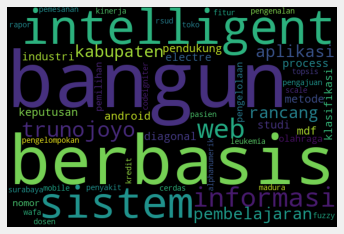

In [34]:
draw_word_cloud(0)

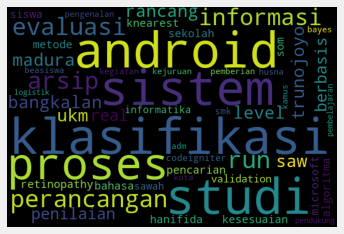

In [35]:
draw_word_cloud(1)